<a href="https://colab.research.google.com/github/tuxsy/iebs-master-data-science/blob/main/m06/c3/AdaBoostRegressor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problemas de regresión con AdaBoost

A continuación vamos a ver un ejemplo sobre cómo entrenar un ensemble mediante el algoritmo **AdaBoost** para un problema de regresión, usando como predictores base modelos de árboles de decisión.

Recordemos que este algoritmo es de naturaleza recursiva, intentando disminuir el error de predicción a medida que incrementamos los iteraciones del mismo.

Cuando explicamos el algoritmo AdaBoost en la parte teórica de la lección dijimos que estaba especializado en tareas de clasificación binaria. Y lo cierto es que en su origen, AdaBoost únicamente focalizado en estas tareas, pero con el tiempo surgieron generalizaciones para problemas de tipo multiclase y de regresión. Concretamente para la parte de regresión en 1997 se presentó el algoritmo [AdaBoost.R2](https://www.researchgate.net/publication/2424244_Improving_Regressors_Using_Boosting_Techniques), que es el algoritmo que está implementado en `scikit-learn` para estas tareas. Concretamente, la clase nos permite hacer esto es `AdaBoostRegressor()`. 



Primeramente lo que tenemos que hacer es cargar todos los módulos que necesitamos.

In [1]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np

En el [artículo](https://www.researchgate.net/publication/2424244_Improving_Regressors_Using_Boosting_Techniques) de referencia de este algoritmo se empleaba el dataset de Boston, así que hemos creído conveniente, por propósitos didácticos, mostrar como se implementa ahora el algoritmo `AdaBoostRegressor()` sobre este conjunto de datos. Veamos como se hace.

Este conjunto de datos contiene la información de los precios de las casas de Boston. Para facilidad nuestra, ya viene instalado con `scikit-learn`. Por lo que procedemos a cargar los datos.

In [2]:
boston = load_boston() 

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset (i.e.

Veamos cómo están estructurados los datos. 

In [3]:
boston

{'data': array([[6.3200e-03, 1.8000e+01, 2.3100e+00, ..., 1.5300e+01, 3.9690e+02,
         4.9800e+00],
        [2.7310e-02, 0.0000e+00, 7.0700e+00, ..., 1.7800e+01, 3.9690e+02,
         9.1400e+00],
        [2.7290e-02, 0.0000e+00, 7.0700e+00, ..., 1.7800e+01, 3.9283e+02,
         4.0300e+00],
        ...,
        [6.0760e-02, 0.0000e+00, 1.1930e+01, ..., 2.1000e+01, 3.9690e+02,
         5.6400e+00],
        [1.0959e-01, 0.0000e+00, 1.1930e+01, ..., 2.1000e+01, 3.9345e+02,
         6.4800e+00],
        [4.7410e-02, 0.0000e+00, 1.1930e+01, ..., 2.1000e+01, 3.9690e+02,
         7.8800e+00]]),
 'target': array([24. , 21.6, 34.7, 33.4, 36.2, 28.7, 22.9, 27.1, 16.5, 18.9, 15. ,
        18.9, 21.7, 20.4, 18.2, 19.9, 23.1, 17.5, 20.2, 18.2, 13.6, 19.6,
        15.2, 14.5, 15.6, 13.9, 16.6, 14.8, 18.4, 21. , 12.7, 14.5, 13.2,
        13.1, 13.5, 18.9, 20. , 21. , 24.7, 30.8, 34.9, 26.6, 25.3, 24.7,
        21.2, 19.3, 20. , 16.6, 14.4, 19.4, 19.7, 20.5, 25. , 23.4, 18.9,
        35.4, 24.7, 3

Nuevamente los datos vienen en formato diccionario, el cual almacena diferente información acerca del problema la cual es accesible a través de un conjunto de claves del diccionario.

In [4]:
boston.keys()

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'filename', 'data_module'])

In [5]:
print(boston.DESCR)

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

Definimos dos arrays de datos, uno que contenga las features (x) y otro con los valores de la variable a predecir (y). Y dividimos el conjunto de datos ente datos de entrenamiento y test.




In [6]:
x, y = boston.data, boston.target
xtrain, xtest, ytrain, ytest=train_test_split(x, y, test_size=0.15)

Ahora utilizamos la clase [`AdaBoostRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostRegressor.html). Observar que en el hiperparámetro `base_estimator` le hemos indicado que utilice arboles de decisión para regresión (`DecisionTreeRegressor`), especificando que tenga `max_depth=3`.

Podríamos haberle indicado otro modelo base débil que sirviese para problemas de regresión. Normalmente, AdaBoost muestra mejores resultado cuando los modelos base son 'weak learners' o modelos muy básicos.

In [7]:
regresor = AdaBoostRegressor(
    base_estimator= DecisionTreeRegressor(max_depth=3),
    n_estimators=100,
    learning_rate=1)
print(regresor)

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=3),
                  learning_rate=1, n_estimators=100)


In [8]:
# ajustamos el modelo
regresor.fit(xtrain, ytrain)

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=3),
                  learning_rate=1, n_estimators=100)

Si queremos obtener una estimación más robusta del accuracy del modelo podemos emplear el método de validación cruzada. En este caso utilizamos el método k-fold con 10 grupos y con barajeo de las observaciones.

In [9]:
kfold = KFold(n_splits=10, shuffle=True)
kf_cv_scores = cross_val_score(regresor, xtrain, ytrain, cv=kfold )
print("K-fold CV promedio score: %.2f" % kf_cv_scores.mean())
print("K-fold CV desviación estándar: %.2f" % kf_cv_scores.std())



K-fold CV promedio score: 0.80
K-fold CV desviación estándar: 0.07


A continuación, utilizamos las observaciones del conjunto test para obtener su predicción y después evaluamos la efectividad del modelo mediante [MSE](https://scikit-learn.org/stable/modules/model_evaluation.html#mean-squared-error) Y RMSE.

In [10]:
ypred = regresor.predict(xtest)
mse = mean_squared_error(ytest,ypred)
print("MSE: %.2f" % mse)
print("RMSE: %.2f" % np.sqrt(mse))

MSE: 13.62
RMSE: 3.69


Por último, vamos a representar en un mismo grádico los valores reales (azul) y los valores predichos. Esto nos va a permitir evaluar de manera visual las desviaciones del modelo.


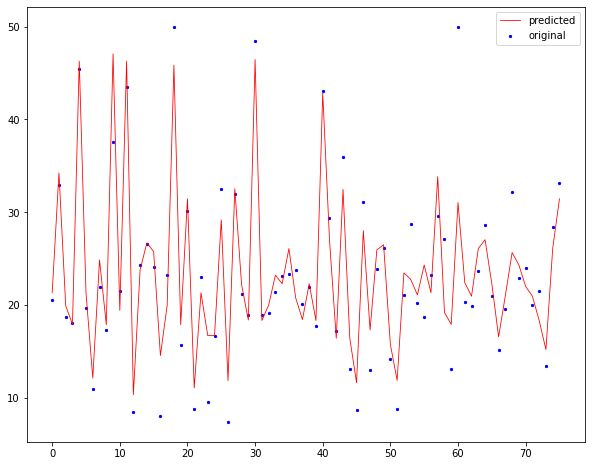

In [11]:
x_ax = range(len(ytest))
plt.figure(figsize=(10,8))
plt.scatter(x_ax, ytest, s=5, color="blue", label="original")
#plt.scatter(x_ax, ypred, s=5, color="red", label="predicted")
plt.plot(x_ax, ypred, lw=0.8, color="red", label="predicted")
plt.legend()
plt.show()

**EJERCICIOS PROPUESTOS**

*   Prueba a **modificar la profundidad máxima** del árbol que se ha utilizado en el ejemplo, o utiliza algún tipo de estrategia de optimización de hiperparámetros y comprueba el efecto que tiene sobre el accuracy del modelo.

* Utiliza con **otro modelo base**  para el algoritmo AdaBoost que pueda ser aplicado para problemas de regresión, calcula su métricas más relevantes y comprueba si mejoran o empeoran los resultados comparados.


**¡Anímate a discutir las configuraciones y modelos que has probado, y comentar los resultados obtenidos en el foro de clase, con el resto de compañer@s!** 😃